In [1]:
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F
import os
import torch


In [2]:
from torch.utils.data import DataLoader


In [3]:
from data.dataloader import CustomDataset
from data.utils import DataTransform
from model.blocks.contourlet import ContourletTransform
from model.blocks.directionalfusion import DirectionalFusion
from model.blocks.unet import UNet


/home/user/anaconda3/envs/jih_icicic/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
transform=DataTransform(image_size=640)

dataset = CustomDataset(
    path="data/1_train/1_LOLdataset",
    transform=transform
)


In [5]:
batch_size = 4

dataloader = DataLoader(
    dataset=dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=int(os.cpu_count() * 0.9),
    persistent_workers=True,
    pin_memory=True
)


In [6]:
data = next(iter(dataloader))
print(data.shape)


torch.Size([4, 3, 640, 640])


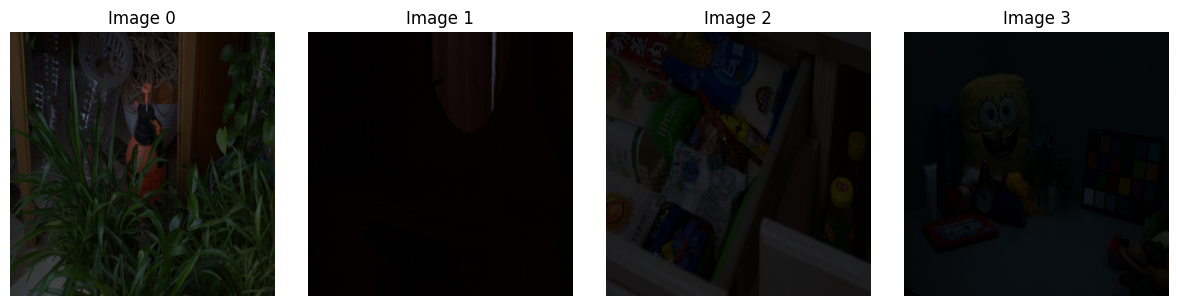

In [7]:
def show_batch(images, ncols=8):
    nimgs = images.shape[0]
    nrows = (nimgs + ncols - 1) // ncols
    plt.figure(figsize=(ncols * 3, nrows * 3))
    for i in range(nimgs):
        plt.subplot(nrows, ncols, i + 1)
        plt.imshow(X=F.to_pil_image(pic=images[i]))
        plt.axis('off')
        plt.title(label=f"Image {i}")
    plt.tight_layout()
    plt.show()

show_batch(images=data)


In [8]:
contourlet = ContourletTransform(
    num_levels=4,
    filter_size=5,
    sigma=1.0,
    omega_x=0.25,
    omega_y=0.25,
    channels=3
)

directioanlfusion = DirectionalFusion(
    in_channels=3,
    hidden_channels=64,
    num_levels=4,
    squeeze_ratio=0.3
)

unet = UNet(
    in_channels=3,
    out_channels=3,
    hidden_channels=64,
    num_levels=3,
    temb_dim=64,
    dropout=0.1,
    shortcut=True,
    trainable=False
)


/home/user/anaconda3/envs/jih_icicic/lib/python3.11/site-packages/torch/functional.py:513: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3609.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [9]:
data = data.cuda()
t = torch.randint(low=0, high=10000, size=(batch_size,)).cuda()

contourlet = contourlet.cuda()
directioanlfusion = directioanlfusion.cuda()
unet = unet.cuda()

pyramid, subbands = contourlet(data)
fusion = directioanlfusion(subbands)
out = unet(data, t, pyramid, fusion)


0
1
2
0
1
2


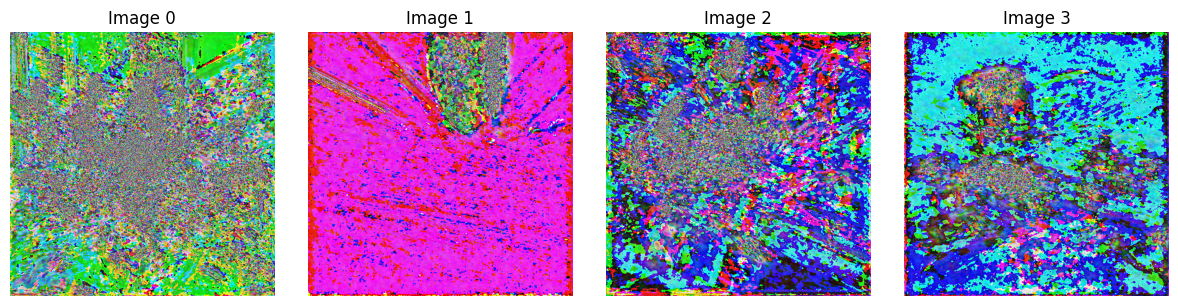

In [10]:
show_batch(images=out)
